In [1]:
import os
import random
import shutil
import copy
import time
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np 
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from glob import glob
from skimage.io import imread
from os import listdir

C:\Users\alvaro.rlanceta\AppData\Local\anaconda3\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# Ruta de la carpeta principal
main_folder = "\\datasetsClases"

# ResNet input size
input_size = (224, 224)

In [3]:
# Just normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")


Initializing Datasets and Dataloaders...


In [4]:
# Batch size for training (change depending on how much memory you have)
batch_size = 8 #8

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(main_folder, x), data_transforms[x]) for x in ['train', 'val','test']}

# Generamos los índices para el subconjunto
subset_indices_train = torch.randperm(len(image_datasets['train']))[:int(0.3*len(image_datasets['train']))]
subset_indices_val = torch.randperm(len(image_datasets['val']))[:int(0.3*len(image_datasets['val']))]
subset_indices_test = torch.randperm(len(image_datasets['test']))[:int(0.3*len(image_datasets['test']))]

# Creamos los subconjuntos
train_data_subset = torch.utils.data.Subset(image_datasets['train'], subset_indices_train)
val_data_subset = torch.utils.data.Subset(image_datasets['val'], subset_indices_val)
test_data_subset = torch.utils.data.Subset(image_datasets['test'], subset_indices_test)

# Create training and validation dataloaders
dataloaders_dict = {
    'train': torch.utils.data.DataLoader(train_data_subset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(val_data_subset, batch_size=batch_size, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(test_data_subset, batch_size=batch_size, shuffle=True, num_workers=4),
}


In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    acc_history = {"train": [], "val": []}
    losses = {"train": [], "val": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    losses[phase].append(loss.item())

                    preds = torch.argmax(outputs, dim=1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item() #running_corrects += torch.sum(preds == labels.data).cpu().numpy()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_model_mobile.pt')
            
            acc_history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, losses



In [7]:
def initialize_model(num_classes):
    # Resnet18 
    model = models.mobilenet_v2(pretrained = True)
    
    # Modify the classifier to output a single value (0 or 1)
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(1280, num_classes)
    )
    
    input_size = 224
        
    return model, input_size

In [8]:

# Number of classes in the dataset
num_classes = 2

# Initialize the model
model, input_size = initialize_model(num_classes)

# Print the model we just instantiated
print(model)

# Send the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\alvaro.rlanceta/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|█████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:01<00:00, 9.45MB/s]

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [9]:

# Setup the loss fxn
criterion = nn.CrossEntropyLoss() #nn.BCELoss()

# Number of epochs to train for 
num_epochs = 40

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

In [10]:
import datetime

# Tiempo inicial
start_time = datetime.datetime.now()
# Train and evaluate
model, hist, losses = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/39
----------
train Loss: 0.4055 Acc: 0.8254
val Loss: 0.3247 Acc: 0.8583

Epoch 1/39
----------
train Loss: 0.3727 Acc: 0.8401
val Loss: 0.3499 Acc: 0.8482

Epoch 2/39
----------
train Loss: 0.3643 Acc: 0.8451
val Loss: 0.3354 Acc: 0.8602

Epoch 3/39
----------
train Loss: 0.3592 Acc: 0.8455
val Loss: 0.3189 Acc: 0.8661

Epoch 4/39
----------
train Loss: 0.3532 Acc: 0.8507
val Loss: 0.3436 Acc: 0.8550

Epoch 5/39
----------
train Loss: 0.3552 Acc: 0.8478
val Loss: 0.3280 Acc: 0.8571

Epoch 6/39
----------
train Loss: 0.3526 Acc: 0.8501
val Loss: 0.3208 Acc: 0.8668

Epoch 7/39
----------
train Loss: 0.3558 Acc: 0.8490
val Loss: 0.3243 Acc: 0.8669

Epoch 8/39
----------
train Loss: 0.3494 Acc: 0.8520
val Loss: 0.3144 Acc: 0.8667

Epoch 9/39
----------
train Loss: 0.3428 Acc: 0.8547
val Loss: 0.3076 Acc: 0.8733

Epoch 10/39
----------
train Loss: 0.3377 Acc: 0.8563
val Loss: 0.3121 Acc: 0.8682

Epoch 11/39
----------
train Loss: 0.3365 Acc: 0.8582
val Loss: 0.3059 Acc: 0.8724

Ep

In [11]:
end_time = datetime.datetime.now()

# Calculando la diferencia de tiempo
duration = end_time - start_time

print(f"Tiempo de ejecución: {duration}")

Tiempo de ejecución: 1 day, 15:35:44.048564


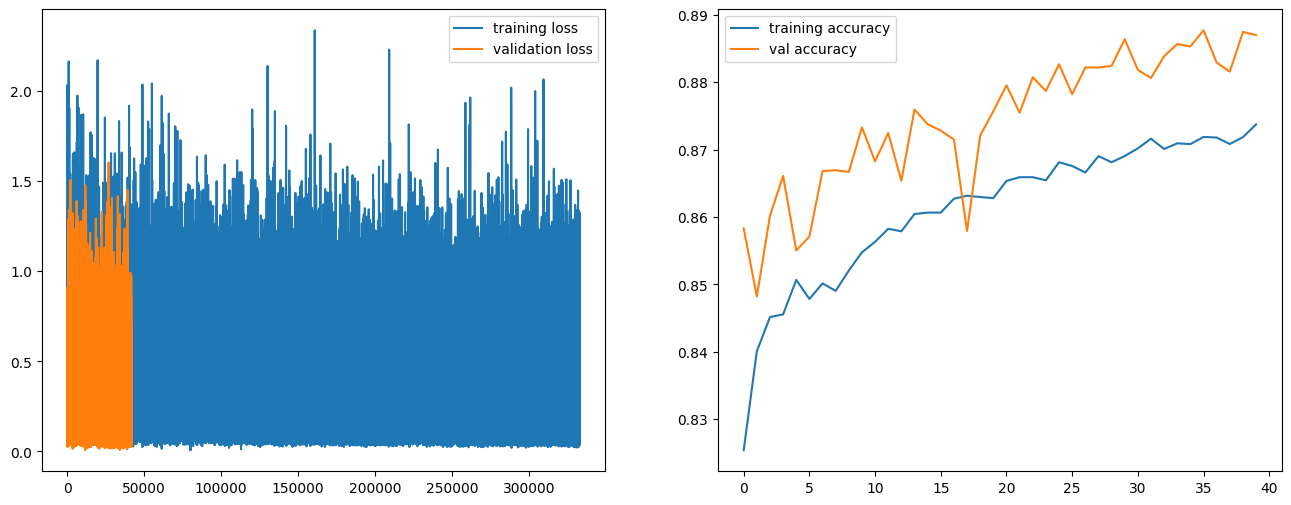

In [12]:
# Plot the losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(losses["train"], label="training loss")
ax1.plot(losses["val"], label="validation loss")
ax1.legend()

ax2.plot(hist["train"],label="training accuracy")
ax2.plot(hist["val"],label="val accuracy")
ax2.legend()

plt.show()

In [13]:
subset_indices_test = torch.randperm(len(image_datasets['test']))[:int(0.3*len(image_datasets['test']))]
test_data_subset = torch.utils.data.Subset(image_datasets['test'], subset_indices_test)
test_dataloader = torch.utils.data.DataLoader(test_data_subset, batch_size=batch_size, shuffle=True, num_workers=4)

In [14]:
def evaluate_model(model, dataloader):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).item()

    loss = running_loss / len(dataloader.dataset)
    accuracy = running_corrects / len(dataloader.dataset)

    return loss, accuracy

test_loss, test_accuracy = evaluate_model(model, test_dataloader)

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(test_loss, test_accuracy))


Test Loss: 0.2651, Test Accuracy: 0.8889


In [36]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataloader):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).item()

            # Save predictions and labels for classification report
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    loss = running_loss / len(dataloader.dataset)
    accuracy = running_corrects / len(dataloader.dataset)
    
    # Convert lists of batches into single tensors
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return loss, accuracy, all_preds, all_labels

# Use the modified function to get loss, accuracy, predictions, and actual labels
test_loss, test_accuracy, test_preds, test_labels = evaluate_model(model, test_dataloader)

# Print loss and accuracy
print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(test_loss, test_accuracy))

# Calculate and print the classification report
print(classification_report(test_labels.numpy(), test_preds.numpy()))

Test Loss: 0.2651, Test Accuracy: 0.8889
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      5907
           1       0.82      0.79      0.81      2420

    accuracy                           0.89      8327
   macro avg       0.87      0.86      0.86      8327
weighted avg       0.89      0.89      0.89      8327



In [15]:
list_img_names = []

counter = 0
for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    for j in range(inputs.size(0)):
        # Obtener el nombre de la imagen
        image_index = i * test_dataloader.batch_size + j
        image_path = test_data_subset.dataset.samples[image_index][0]
        image_name = os.path.basename(image_path)
        print("Nombre de la imagen: {}".format(image_name))
        list_img_names.append(image_name)
        # Loading and showing the image
        image = inputs[j].permute(1, 2, 0).cpu().numpy()

        # Normalizing the image
        image = (image - image.min()) / (image.max() - image.min())

        """
        plt.figure()
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        """
        # Print the prediction and the correct label
        prediction = preds[j].item()
        correct_label = labels[j].item()
        print("Predicción: {}, Etiqueta correcta: {}".format(prediction, correct_label))

Nombre de la imagen: 10253_idx5_x1001_y1301_class0.png
Predicción: 0, Etiqueta correcta: 0
Nombre de la imagen: 10253_idx5_x1001_y751_class0.png
Predicción: 0, Etiqueta correcta: 0
Nombre de la imagen: 10253_idx5_x1051_y1151_class0.png
Predicción: 0, Etiqueta correcta: 1
Nombre de la imagen: 10253_idx5_x1051_y151_class0.png
Predicción: 0, Etiqueta correcta: 0
Nombre de la imagen: 10253_idx5_x1101_y1101_class0.png
Predicción: 0, Etiqueta correcta: 0
Nombre de la imagen: 10253_idx5_x1101_y351_class0.png
Predicción: 0, Etiqueta correcta: 0
Nombre de la imagen: 10253_idx5_x1101_y851_class0.png
Predicción: 0, Etiqueta correcta: 0
Nombre de la imagen: 10253_idx5_x1201_y1201_class0.png
Predicción: 0, Etiqueta correcta: 0
Nombre de la imagen: 10253_idx5_x1251_y1151_class0.png
Predicción: 0, Etiqueta correcta: 0
Nombre de la imagen: 10253_idx5_x1251_y1201_class0.png
Predicción: 1, Etiqueta correcta: 1
Nombre de la imagen: 10253_idx5_x1251_y751_class0.png
Predicción: 1, Etiqueta correcta: 0
Nomb

In [16]:
patient_ids = []
for name in list_img_names:
    id = name.split('_')[0]
    patient_ids.append(id)

In [17]:
ids_unique = list(set(patient_ids))

In [30]:
base_path = 'C:\\Users\\alvaro.rlanceta\\Documents\\tfm\\archive'

In [31]:
def visualise_breast_tissue_base(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape=(max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape=(max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape=(max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            target = example_df.target.values[n]
            x_coord = int(example_df.x.values[n])
            y_coord = int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                proba = patient_df[(patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    return grid, mask, broken_patches, mask_proba

In [32]:
def visualise_breast_tissue(patient_id):
    grid, mask, broken_patches,_ = visualise_breast_tissue_base(patient_id)

    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].imshow(grid, alpha=0.9)
    ax[1].imshow(mask, alpha=0.8)
    ax[1].imshow(grid, alpha=0.7)
    ax[0].grid(False)
    ax[1].grid(False)
    for m in range(2):
        ax[m].set_xlabel("X-coord")
        ax[m].set_ylabel("Y-coord")
    ax[0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id)

    plt.show()

In [33]:
def visualise_breast_tissue_binary(patient_id):
        
    fig, ax = plt.subplots(1, 1)

    example_df = get_patient_dataframe(patient_id)

    ax.scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20)
    ax.set_title("Patient " + patient_id)
    ax.set_xlabel("X coord")
    ax.set_ylabel("Y coord")
    ax.set_aspect('equal')  # Set aspect ratio to 'equal' to preserve original orientation
    ax.invert_yaxis()  # Reverse the y-axis direction

    plt.show()


In [34]:
# Obtener 5 elementos aleatorios de la lista
random_patient_ids = random.sample(patient_ids, k=5)

In [1]:
for id in random_patient_ids: #ids_unique:
    print("Patient's ID: ", id)
    visualise_breast_tissue(id)
    visualise_breast_tissue_binary(id)
    print("\n")

NameError: name 'random_patient_ids' is not defined